In [98]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

1. Загрузите изображение в оттенках серого sar_1_gray.jpg 

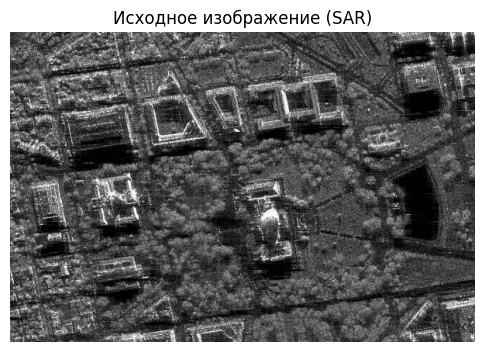

In [99]:
img = cv2.imread('sar_1_gray.jpg', cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError('Не удалось загрузить sar_1_gray.jpg')

plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.title('Исходное изображение (SAR)')
plt.axis('off')
plt.show()

2.  Постройте гистограмму

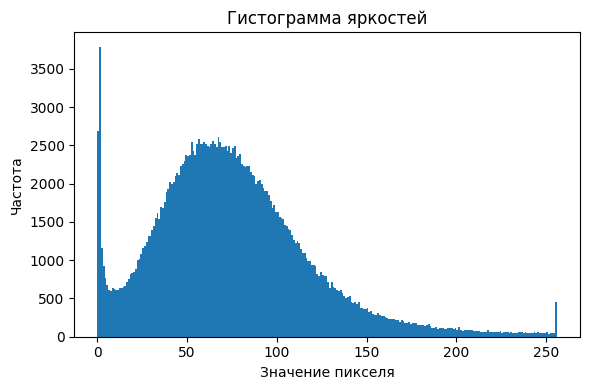

In [100]:
plt.figure(figsize=(6, 4))
plt.hist(img.ravel(), bins=256, range=(0, 256))
plt.title('Гистограмма яркостей')
plt.xlabel('Значение пикселя')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

3. Реализуйте алгоритм гамма коррекции с параметром гамма <1, 1>

In [101]:
def gamma_correction(image, gamma):
    if gamma <= 0:
        raise ValueError('Параметр gamma должен быть положительным')
    norm = image.astype(np.float32) / 255.0
    corrected = np.power(norm, gamma)
    corrected = np.clip(corrected * 255, 0, 255)
    return corrected.astype(np.uint8)

In [102]:
gamma_low = 0.5
gamma_high = 1.5
img_gamma_low = gamma_correction(img, gamma_low)
img_gamma_high = gamma_correction(img, gamma_high)

(np.float64(-0.5), np.float64(599.5), np.float64(399.5), np.float64(-0.5))

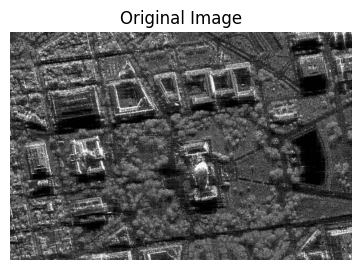

In [103]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

(np.float64(-0.5), np.float64(599.5), np.float64(399.5), np.float64(-0.5))

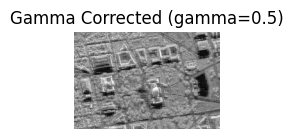

In [104]:
plt.subplot(1, 3, 2)
plt.imshow(img_gamma_low, cmap='gray')
plt.title(f'Gamma Corrected (gamma={gamma_low})')
plt.axis('off')

(np.float64(-0.5), np.float64(599.5), np.float64(399.5), np.float64(-0.5))

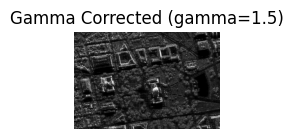

In [105]:
plt.subplot(1, 3, 3)
plt.imshow(img_gamma_high, cmap='gray')
plt.title(f'Gamma Corrected (gamma={gamma_high})')
plt.axis('off')

In [106]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

4. Сравните исходное изображение, скорректированное при помощи гамма-фильтра. MSE, SSIM    

In [107]:
def mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

In [108]:
def calculate_ssim(image1, image2):
    return ssim(image1, image2, data_range=255)

In [109]:
mse_low = mse(img, img_gamma_low)
mse_high = mse(img, img_gamma_high)
ssim_low = calculate_ssim(img, img_gamma_low)
ssim_high = calculate_ssim(img, img_gamma_high)

In [110]:
print(f'MSE (gamma={gamma_low}): {mse_low}')
print(f'SSIM (gamma={gamma_low}): {ssim_low}')
print(f'MSE (gamma={gamma_high}): {mse_high}')
print(f'SSIM (gamma={gamma_high}): {ssim_high}')

MSE (gamma=0.5): 102.92194583333334
SSIM (gamma=0.5): 0.7875008686792753
MSE (gamma=1.5): 109.49745416666667
SSIM (gamma=1.5): 0.8065788107754002


5. Реализуйте алгоритм статистической цветокоррекции на основе статистики eq_gray

In [111]:
eq_gray = cv2.equalizeHist(img)


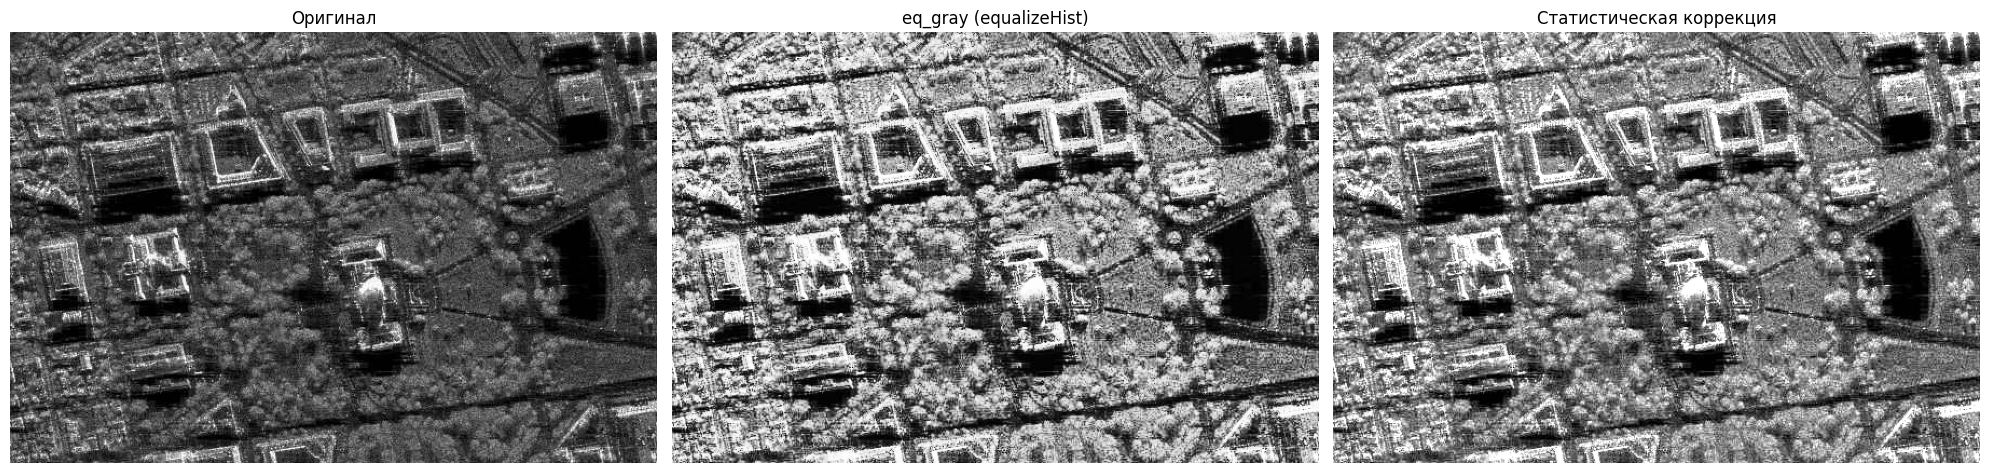

In [112]:
def stat_corr_algo(src, ref):
    src = src.astype(np.float32)
    ref = ref.astype(np.float32)

    mean_src, std_src = src.mean(), src.std()
    mean_ref, std_ref = ref.mean(), ref.std()

    if std_src < 1e-6:
        raise ValueError('Стандартное отклонение исходного изображения слишком мало')

    stat_corrected = (src - mean_src) * (std_ref / std_src) + mean_ref
    return np.clip(stat_corrected, 0, 255).astype(np.uint8)

img_stat_corrected = stat_corr_algo(img, eq_gray)
img_eq = eq_gray.copy()
img_diff = cv2.absdiff(img_eq, img_stat_corrected)

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].imshow(img, cmap='gray'); axs[0].set_title('Оригинал')
axs[1].imshow(img_eq, cmap='gray'); axs[1].set_title('eq_gray (equalizeHist)')
axs[2].imshow(img_stat_corrected, cmap='gray'); axs[2].set_title('Статистическая коррекция')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [113]:
print('MSE (equalizeHist vs original):', mse(img, img_eq))
print('SSIM (equalizeHist vs original):', calculate_ssim(img, img_eq))
print('MSE (stat corr vs original):', mse(img, img_stat_corrected))
print('SSIM (stat corr vs original):', calculate_ssim(img, img_stat_corrected))
print('MSE (equalizeHist vs stat corr):', mse(img_eq, img_stat_corrected))
print('SSIM (equalizeHist vs stat corr):', calculate_ssim(img_eq, img_stat_corrected))

MSE (equalizeHist vs original): 100.64574583333334
SSIM (equalizeHist vs original): 0.6991361032506224
MSE (stat corr vs original): 112.38938333333333
SSIM (stat corr vs original): 0.7862101987758863
MSE (equalizeHist vs stat corr): 89.2092875
SSIM (equalizeHist vs stat corr): 0.9500070636130857


6. Протестируйте работу алгоритмов пороговой фильтрации с различными параметрами

In [114]:
_, thresh_binary_90 = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
_, thresh_binary_150 = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
_, thresh_binary_inv = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV)
_, thresh_trunc = cv2.threshold(img, 127, 255, cv2.THRESH_TRUNC)
_, thresh_tozero = cv2.threshold(img, 127, 255, cv2.THRESH_TOZERO)
_, thresh_tozero_inv = cv2.threshold(img, 127, 255, cv2.THRESH_TOZERO_INV)
_, thresh_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
adaptive_mean = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                      cv2.THRESH_BINARY, 11, 2)
adaptive_gauss = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 2)

In [115]:
threshold_results = [
    ('Binary T=90', thresh_binary_90),
    ('Binary T=150', thresh_binary_150),
    ('Binary Inv T=120', thresh_binary_inv),
    ('Trunc T=127', thresh_trunc),
    ('ToZero T=127', thresh_tozero),
    ('ToZero Inv T=127', thresh_tozero_inv),
    ('Binary Otsu', thresh_otsu),
    ('Adaptive Mean', adaptive_mean),
    ('Adaptive Gaussian', adaptive_gauss),
]

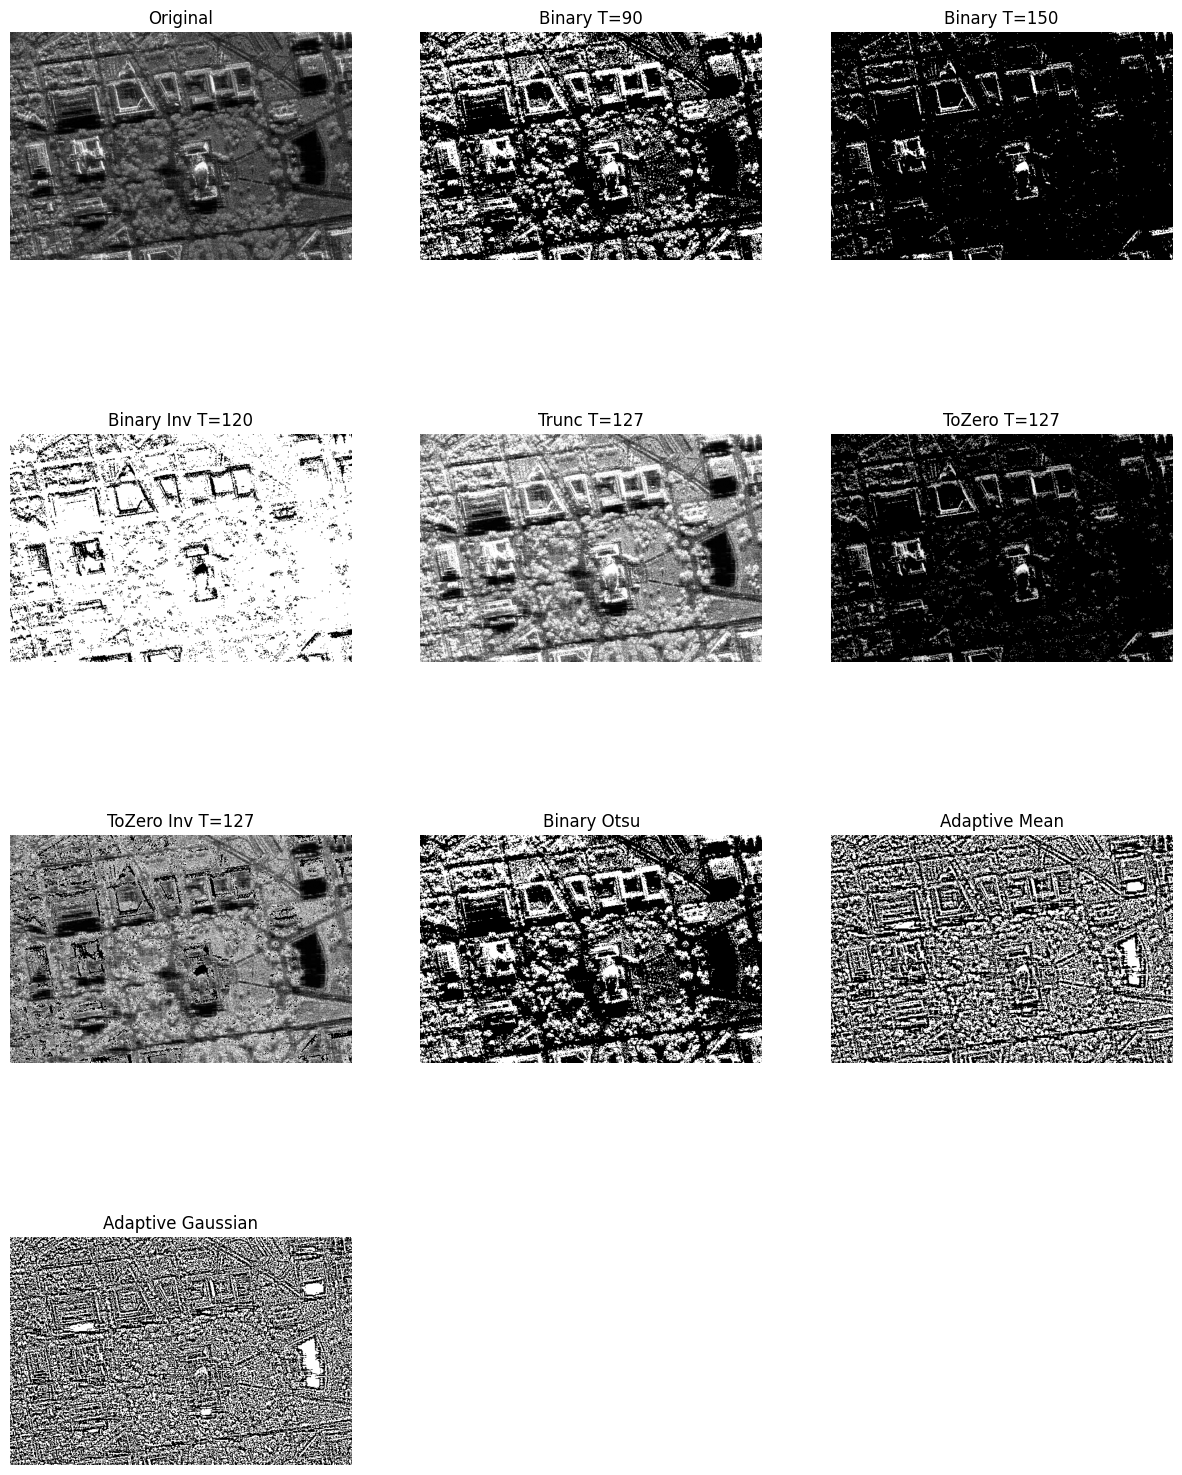

In [116]:
cols = 3
rows = int(np.ceil((len(threshold_results) + 1) / cols))
plt.figure(figsize=(15, 5 * rows))

plt.subplot(rows, cols, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')

for idx, (title, image_thresh) in enumerate(threshold_results, start=2):
    plt.subplot(rows, cols, idx)
    plt.imshow(image_thresh, cmap='gray')
    plt.title(title)
    plt.axis('off')

In [117]:
plt.show()